In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textblob import TextBlob, classifiers

import re, string, timeit
from wordcloud import WordCloud
import scipy
import pyreadstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation as LDA
import csv

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daisy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Importing in the dataset containing sentiment values and sentiment labels.

In [2]:
sightings_merged = pd.read_pickle('sightings_merged_w_label.pkl')

In [3]:
sightings_merged.head(2)

,Date_Time,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary,Detail_Summary_nltk,Notes,Country,...,Lon,timezone_str,Time_UTC,sentiment_Vader,sentiment_nltk,sentiment_TextBlob,objectivity_TextBlob,sentiment_Vader_label,sentiment_nltk_label,sentiment_TextBlob_label
0,2021-04-23,Circle,9 minutes,Very strange ((NUFORC Note: Rocket launch f...,4/23/21,http://www.nuforc.org/webreports/162/S162815.html,\nVery strangeI have recorded a video of this ...,strange recorded video fightingCircle,NaN,United States,...,-82.240580,America/New_York,2021-04-23 04:00:00+00:00,0.0000,-0.2023,-0.05,0.150000,neutral,negative,neutral
1,2021-04-23,Circle,Seconds,Ball in the sky ((NUFORC Note: Rocket launc...,4/23/21,http://www.nuforc.org/webreports/162/S162814.html,\nBall in the skyObject appears as a white bal...,ball skyobject appears white ball vapor screwi...,NaN,United States,...,-79.974385,America/New_York,2021-04-23 04:00:00+00:00,0.7343,0.3818,-0.02,0.376667,very positive,positive,neutral


Visualizing the histograms of the continuous sentiment values along with the buketized sentiment values.

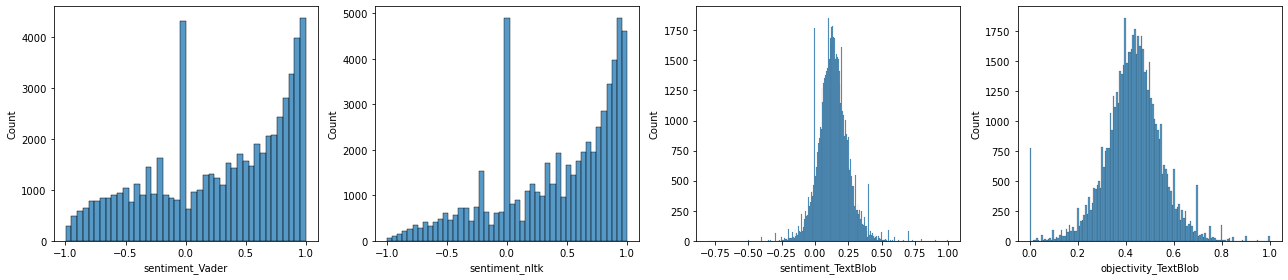

In [4]:
fig,axes = plt.subplots(1,4,figsize=(18,4))
axes = axes.ravel() # flatten
columns_raw = ['sentiment_Vader', 'sentiment_nltk', 'sentiment_TextBlob', 'objectivity_TextBlob']
for i in range(0,4):
    sns.histplot(ax=axes[i], data=sightings_merged, x=columns_raw[i])
plt.tight_layout()
plt.show()

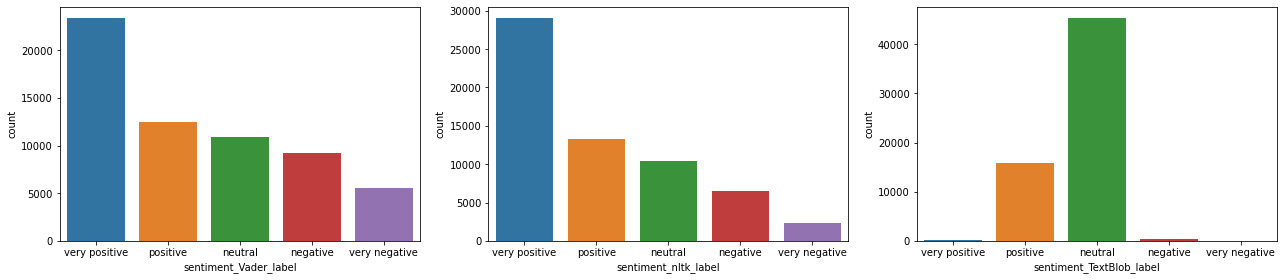

In [5]:
fig,axes = plt.subplots(1,3,figsize=(18,4))
axes = axes.ravel() # flatten
columns_label = ['sentiment_Vader_label', 'sentiment_nltk_label', 'sentiment_TextBlob_label']
for i in range(0,3):
    sns.countplot(ax= axes[i], x=columns_label[i], data=sightings_merged, order=['very positive', 'positive', 'neutral', 'negative', 'very negative']);
plt.tight_layout()
plt.show()

Text Data Exploration

In [6]:
# creating the Bag of words Model for WordClouds
BagOfWords = []
for s in sightings_merged['Detail_Summary_nltk']:
    s = re.sub(r' . ', " ", s)
    s = re.sub(r'[\(\)\[\]\^\$\+\*\.\?\/!@#%&{}\'\",;:]', "", s)
    words = nltk.word_tokenize(s)
    BagOfWords.append(words)

In [7]:
BagOfWords_series = pd.Series(BagOfWords)
BagOfWords_list = ''.join(BagOfWords_series.str.join(',').tolist()).split(',')

In [8]:
text_Data = sightings_merged[['Summary']].copy()
text_Data['Summary'] = text_Data['Summary'].apply(lambda x: re.sub(r'\n', " ", x))

Defining functions for summary statistics of text data.

In [9]:
def count_stopwords(text, stopwords):
    """
    Function that counts the number of stopwords in text.
        Args:
            - text: str
            - stopwords: list of str, containing the stopwords
        Return:
            - int, number of stopwords in the text argument
    """
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w.lower() in stopwords]
    
    return len(stopwords_x)
  
# Calculate the number of sentences in summaries
text_Data['sentence_count'] = text_Data['Summary'].apply(lambda x : len(sent_tokenize(x)))

# Calculate number of words in summaries
text_Data['word_count'] = text_Data['Summary'].apply(lambda x : len(x.split()))

# Calculate number of characters in the summary
text_Data['character_count'] = text_Data['Summary'].apply(lambda x : len(x.replace(" ","")))

# Stopwords
stops = set(stopwords.words('english'))

# Calculate the number of stopwords in the summary
text_Data['stopwords_count'] =  text_Data['Summary'].apply(lambda x : count_stopwords(x, stops))

In [10]:
text_Data[['sentence_count', 'word_count', 'character_count', 'stopwords_count']].describe()

,sentence_count,word_count,character_count,stopwords_count
count,61647.000000,61647.000000,61647.000000,61647.000000
mean,1.288968,14.035752,67.396564,4.761935
std,0.634887,7.330619,30.248959,4.191004
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,8.000000,42.000000,2.000000
50%,1.000000,13.000000,64.000000,3.000000
75%,1.000000,20.000000,97.000000,7.000000
max,8.000000,36.000000,135.000000,24.000000


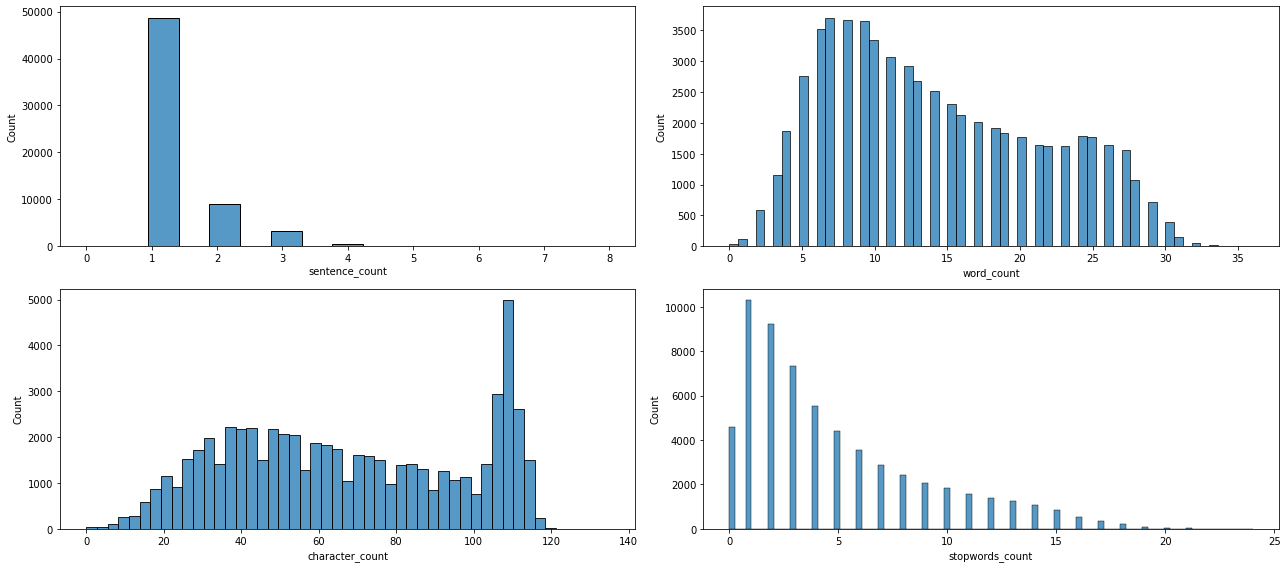

In [11]:
fig,axes = plt.subplots(2,2,figsize=(18,8))
axes = axes.ravel() # flatten
columns = ['sentence_count', 'word_count', 'character_count', 'stopwords_count']
for i in range(0,4):
    sns.histplot(ax=axes[i], data=text_Data, x=columns[i])
plt.tight_layout()
plt.show()

In [12]:
text_Data.columns

Index(['Summary', 'sentence_count', 'word_count', 'character_count',
       'stopwords_count'],
      dtype='object')

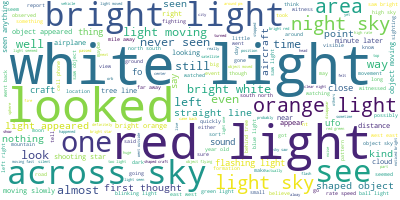

In [13]:
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
cleanedText = " ".join(t for t in BagOfWords_list)
wordcloud.generate(cleanedText)
# Visualize the word cloud
wordcloud.to_image()

Topic Modeling with LDA

In [14]:
# Initialise the count vectorizer
count_vec = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
ctVec = count_vec.fit_transform(sightings_merged['Detail_Summary_nltk'])
# Build the Document Term Matrix
words = count_vec.get_feature_names()
term_matrix = pd.DataFrame(ctVec.toarray(), columns=list(words))

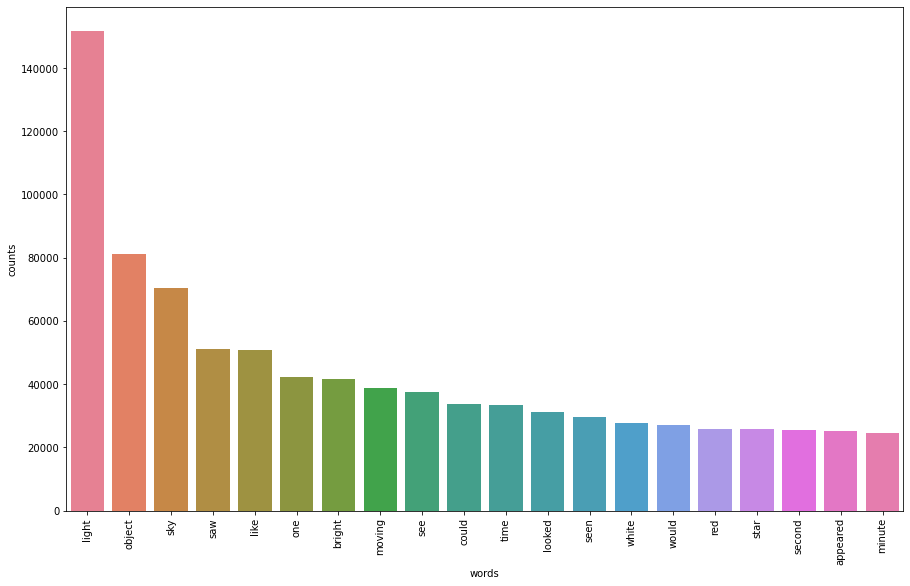

In [15]:
total_counts = np.zeros(len(words))
for val in ctVec:
    total_counts+=val.toarray()[0]
    
count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 
    
plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot()
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x = x_pos, y = counts, palette='husl')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

Note: LDA model takes some time to run.

In [17]:
# Topic Modeling - 10 topics
lda_model = LDA(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(ctVec)
# Show the topics and the 8 more relevant words in each topic
top_words_num = 8
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, count_vec, top_words_num)

Topics found via LDA:


In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    """
    Function that prints the topics detected and the n_top_words that it contains
    Args:
       - model: LDA model for the text
       - count_vectorizer: the count vectorizer object
       - n_top_words: the number of words to consider in a topic
    """ 
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Show the topics and the 12 more relevant words in each topic
top_words_num = 12
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, count_vec, top_words_num)

In [ ]:
#%%script false --no-raise-error
LDAvis_data_fileName = 'ldavis_prepared_'

LDAvis_prepared = sklearn_lda.prepare(lda_model, ctVec, count_vec)
with open(LDAvis_data_fileName, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_fileName,'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, 'SightingsSummaryLDAvis.html')